downloaded s3://deeplens-analogue-guage-727949722849/images/gauge-6.jpg as gauge-6.jpg


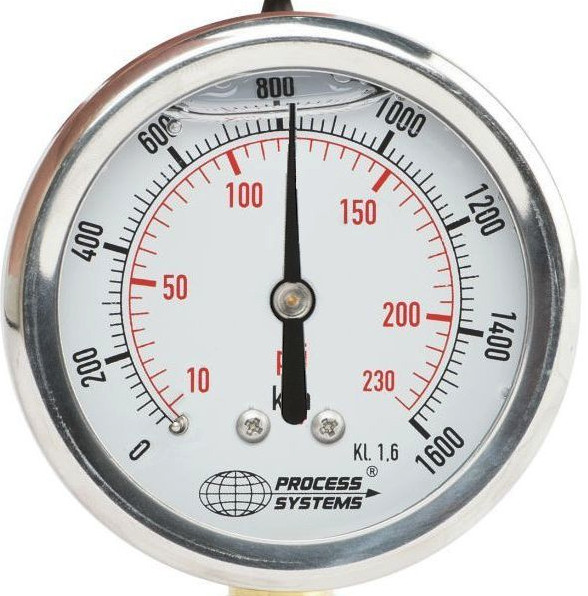

In [1]:
import boto3
import cv2
import numpy as np
import time
from pathlib import Path

from IPython.display import Image

boto3 = boto3.session.Session(profile_name='stem')
s3_client = boto3.client('s3')

# get S3 image details
s3Bucket = 'deeplens-analogue-guage-727949722849'
s3Key = 'training-images/pressure-guage-bp-0020.jpg';

# download file from S3
file_key_prefix = Path(s3Key).stem
file_key_suffix = Path(s3Key).suffix
originalImageFileName = '%s%s'%(file_key_prefix,file_key_suffix)
s3_client.download_file(s3Bucket, s3Key, originalImageFileName)
print('downloaded s3://%s/%s as %s'%(s3Bucket, s3Key, originalImageFileName))

# display original image
display(Image(filename=originalImageFileName, width=300))

In [2]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [263]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [264]:
def calibrate_gauge(file_key_prefix, file_key_suffix):
    '''
        This function should be run using a test image in order to calibrate the range available to the dial as well as the
        units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
        (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
        as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
        position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
        the gauge is linear (as most probably are).
        It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
        and the units (as a string).
    '''
    print('calibrating: %s%s' %(file_key_prefix, file_key_suffix))
    img = cv2.imread('%s%s' %(file_key_prefix, file_key_suffix))
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # gray = cv2.medianBlur(gray, 5)

    #for testing, output gray image
    #cv2.imwrite('%s-bw%s' %(file_key_prefix, file_key_suffix),gray)

    #detect circles
    #restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
    #these are pixel values which correspond to the possible radii search range.
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.50))
    # average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one
    a, b, c = circles.shape
    x,y,r = avg_circles(circles, b)

    # draw center and circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle
    # print ("center (x, y): (%s, %s)" %(x, y))
    
    #for testing, output circles on image
    # cv2.imwrite('%s-circles%s' % (file_key_prefix, file_key_suffix), img)

    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

    '''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
    '''
    separation = 10.0 #in degrees
    interval = int(360 / separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    # get user input on min, max, values, and units
    min_angle = 48 # raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
    max_angle = 310 # raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
    min_value = 10 # raw_input('Min value: ') #usually zero
    max_value = 230 # raw_input('Max value: ') #maximum reading of the gauge
    units = "PSI" # raw_input('Enter units: ')

    # for testing purposes: hardcode and comment out raw_inputs above
    # min_angle = 45
    # max_angle = 320
    # min_value = 0
    # max_value = 200
    # units = "PSI"
    calibrationImageName = '%s-calibration%s'%(file_key_prefix, file_key_suffix)
    cv2.imwrite(calibrationImageName, img)
    print('calibration image: %s' %(calibrationImageName))
    display(Image(filename=calibrationImageName, width=300))
    
    return min_angle, max_angle, min_value, max_value, units, x, y, r

calibrating: gauge-6.jpg
calibration image: gauge-6-calibration.jpg


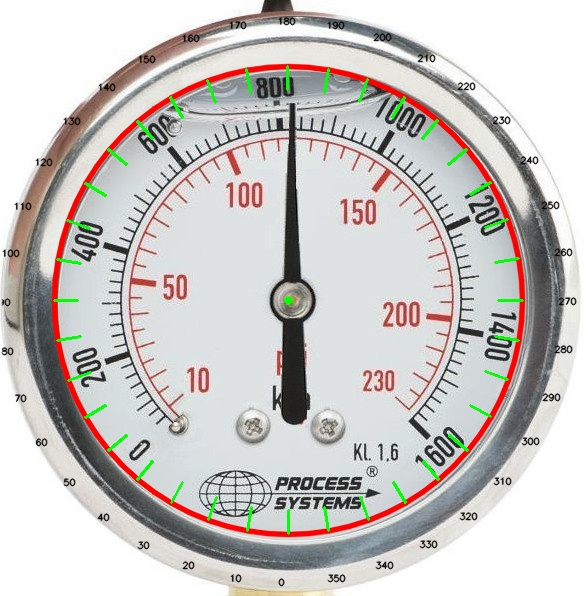

In [265]:
# name the calibration image of your gauge
min_angle, max_angle, min_value, max_value, units, x, y, r = calibrate_gauge(file_key_prefix, file_key_suffix)

In [266]:
def get_current_value(img, min_angle, max_angle, min_value, max_value, units, x, y, r, file_key_prefix, file_key_suffix):

    #for testing purposes
    #img = cv2.imread('%s%s' % (file_key_prefix, file_key_suffix))

    print ("current center (x, y): (%s, %s)" %(x, y))
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Set threshold and maxValue
    thresh = 175
    maxValue = 255

    # for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
    #th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
    #th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
    #th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
    #th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
    #th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
    #cv2.imwrite('%s-dst1%s' % (file_key_prefix, file_key_suffix), dst1)
    #cv2.imwrite('%s-dst2%s' % (file_key_prefix, file_key_suffix), dst2)
    #cv2.imwrite('%s-dst3%s' % (file_key_prefix, file_key_suffix), dst3)
    #cv2.imwrite('%s-dst4%s' % (file_key_prefix, file_key_suffix), dst4)
    #cv2.imwrite('%s-dst5%s' % (file_key_prefix, file_key_suffix), dst5)

    # apply thresholding which helps for finding lines
    th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);

    # found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring
    #dst2 = cv2.medianBlur(dst2, 5)
    #dst2 = cv2.Canny(dst2, 50, 150)
    #dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)

    # for testing, show image after thresholding
    cv2.imwrite('%s-tempdst2%s' % (file_key_prefix, file_key_suffix), dst2)

    # find lines
    minLineLength = 10
    maxLineGap = 0
    lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

    #for testing purposes, show all found lines
    #for i in range(0, len(lines)):
    #  for x1, y1, x2, y2 in lines[i]:
    #     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
     #    cv2.imwrite('%s-lines-test%s' %(file_key_prefix, file_key_suffix), img)

    # remove all lines outside a givehttps://deep-gauge.notebook.us-east-1.sagemaker.aws/notebooks/read-guage.ipynb#n radius
    final_line_list = []
    print ("radius: %s" %r)

    diff1LowerBound = 0.05 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
    diff1UpperBound = 0.20
    diff2LowerBound = 0.6 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
    diff2UpperBound = 1.0
    for i in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
            diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
            #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
            if (diff1 > diff2):
                temp = diff1
                diff1 = diff2
                diff2 = temp
            # check if line is within an acceptable range
            if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
                line_length = dist_2_pts(x1, y1, x2, y2)
                # add to final list
                final_line_list.append([x1, y1, x2, y2])

    #testing only, show all lines after filtering
    # for i in range(0,len(final_line_list)):
    #    x1 = final_line_list[i][0]
    #    y1 = final_line_list[i][1]
    #    x2 = final_line_list[i][2]
    #    y2 = final_line_list[i][3]
    #    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # cv2.imwrite('%s-lines-filtered%s' %(file_key_prefix, file_key_suffix), img)
        
    # assumes the first line is the best one
    x1 = final_line_list[0][0]
    y1 = final_line_list[0][1]
    x2 = final_line_list[0][2]
    y2 = final_line_list[0][3]
    # cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    # print ("(x1, y1): (%s, %s)" %(x1, y1))
    # print ("(x2, y2): (%s, %s)" %(x2, y2))
    
    #draw center and circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(img, (x, y), 8, (0, 255, 0), 8, cv2.LINE_AA)  # draw center of circle

    # print ("center (x, y): (%s, %s)" %(x, y))
    # print ("radius (r): (%s)" %(r))
    
    ## add the dial line
    cv2.line(img, (x, y), (x1, y1), (0, 255, 0), 4)
    
    #for testing purposes, show the line overlayed on the original image
    #cv2.imwrite('gauge-1-test.jpg', img)

    #find the farthest point from the center to be what is used to determine the angle
    dist_pt_0 = dist_2_pts(x, y, x1, y1)
    dist_pt_1 = dist_2_pts(x, y, x2, y2)
    if (dist_pt_0 > dist_pt_1):
        x_angle = x1 - x
        y_angle = y - y1
    else:
        x_angle = x2 - x
        y_angle = y - y2
    # take the arc tan of y/x to find the angle
    res = np.arctan(np.divide(float(y_angle), float(x_angle)))
    # np.rad2deg(res) # coverts to degrees
    # print ("x_angle: %s" %(x_angle))
    # print ("y_angle: %s" %(y_angle))
    # print ("res: %s" %(res))
    # print ("np.rad2deg(res): %s" %(np.rad2deg(res)))
    
    #these were determined by trial and error
    res = np.rad2deg(res)
    if x_angle > 0 and y_angle > 0:  #in quadrant I
        final_angle = 270 - res
    if x_angle < 0 and y_angle > 0:  #in quadrant II
        final_angle = 90 - res
    if x_angle < 0 and y_angle < 0:  #in quadrant III
        final_angle = 90 - res
    if x_angle > 0 and y_angle < 0:  #in quadrant IV
        final_angle = 270 - res

    print ("final_angle: %s" %(final_angle))

    old_min = float(min_angle)
    old_max = float(max_angle)

    new_min = float(min_value)
    new_max = float(max_value)

    old_value = final_angle

    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min

    print ("raw new value: %s" %(new_value))
    # cv2.putText(img, '[%s]' %(new_value), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,0),1,cv2.LINE_AA)

    # print the value text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (2,26)
    fontScale              = 1
    fontColor              = (0,0,0)
    lineType               = 2
    cv2.putText(img,
        '%s %s' %(round(new_value), units), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    # output an image with text
    finalImageName = '%s-lines%s'%(file_key_prefix, file_key_suffix)
    cv2.imwrite(finalImageName, img)
    print('final image: %s' %(finalImageName))
    display(Image(filename=finalImageName, width=300))
    
    return {
        'measurement': 'pressure',
        'value': round(new_value),
        'units': units
    }

current center (x, y): (288, 300)
radius: 234
final_angle: 181.16320624524113
raw new value: 121.81643272501162
final image: gauge-6-lines.jpg


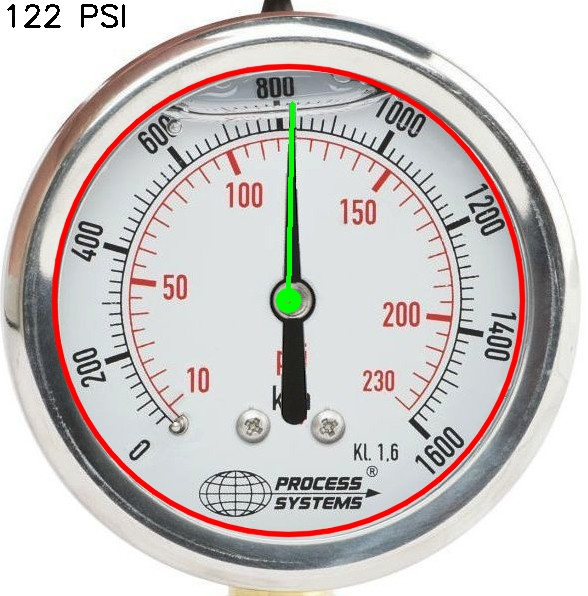

Current reading: {'measurement': 'pressure', 'value': 122, 'units': 'PSI'}


In [267]:
# feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
img = cv2.imread('%s%s' % (file_key_prefix, file_key_suffix))
val = get_current_value(img, min_angle, max_angle, min_value, max_value, units, x, y, r, file_key_prefix, file_key_suffix)
print ("Current reading: %s" %(val))